In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import sys
sys.path += ["../../../MLPF/mlpf/particleflow/mlpf/"]
from tfmodel.model_setup import make_model
from tfmodel.utils import parse_config

import tensorflow as tf
import tensorflow_datasets as tfds

import pathlib

2024-01-27 00:32:38.853244: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
ds_builder = tfds.builder("clic_edm_qq_pf", data_dir = '../../../MLPF/mlpf/tensorflow_datasets/') # Tensorflow datsets positions in the lxplus
dss = ds_builder.as_data_source("test")

In [4]:
def yield_from_ds():
    for elem in dss:
        yield {"X": elem["X"], "ygen": elem["ygen"], "ycand": elem["ycand"]}

In [5]:
output_signature = {k: tf.TensorSpec(shape=(None, v.shape[1])) for (k, v) in dss.dataset_info.features.items()}
tf_dataset = tf.data.Dataset.from_generator(yield_from_ds, output_signature=output_signature).take(100).padded_batch(batch_size=10)

In [6]:
output_signature

{'X': TensorSpec(shape=(None, 17), dtype=tf.float32, name=None),
 'ycand': TensorSpec(shape=(None, 8), dtype=tf.float32, name=None),
 'ygen': TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)}

In [7]:
data = list(tfds.as_numpy(tf_dataset))

In [8]:
Xs = [d["X"] for d in data]
ys = [d["ygen"] for d in data]

In [9]:
ys[0][9][:,:4]

array([[ 1.        , -1.        ,  3.5555263 ,  0.22640967],
       [ 1.        , -1.        ,  2.4462407 ,  0.195159  ],
       [ 1.        ,  1.        ,  0.8356094 , -0.5446882 ],
       [ 1.        ,  1.        ,  0.85157084, -1.37132   ],
       [ 1.        ,  1.        ,  0.6311886 , -0.9460032 ],
       [ 1.        ,  1.        ,  0.560444  , -0.38950145],
       [ 1.        , -1.        ,  0.50040615, -0.29128084],
       [ 1.        , -1.        ,  0.40326795,  0.19255948],
       [ 1.        ,  1.        ,  0.37885737,  0.12188682],
       [ 1.        , -1.        ,  0.36663368, -2.1641972 ],
       [ 1.        ,  1.        ,  0.3846691 ,  0.68863004],
       [ 1.        ,  1.        ,  0.3615032 , -0.81029856],
       [ 1.        , -1.        ,  0.18166022,  0.15179   ],
       [ 1.        , -1.        ,  0.21182844,  1.8761586 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.        , -1.        ,  0.16170818, -0.88895464],
       [ 1.        ,  1.

In [10]:
#batch 0, max 111 particles per event
Xs[0].shape

(10, 111, 17)

In [11]:
#batch 3 has 10 events, max 90 particles per event
Xs[3].shape

(10, 90, 17)

In [12]:
# Check the lengths of sublists in Xs
sublist_lengths = [len(sublist) for sublist in Xs]
print("Lengths of sublists in Xs:", sublist_lengths)


Lengths of sublists in Xs: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


In [13]:
for X_q in Xs:
    print("Shape of X_q:", X_q.shape) 

Shape of X_q: (10, 111, 17)
Shape of X_q: (10, 186, 17)
Shape of X_q: (10, 142, 17)
Shape of X_q: (10, 90, 17)
Shape of X_q: (10, 111, 17)
Shape of X_q: (10, 195, 17)
Shape of X_q: (10, 100, 17)
Shape of X_q: (10, 81, 17)
Shape of X_q: (10, 130, 17)
Shape of X_q: (10, 147, 17)


In [14]:
for y_q in ys:
    print("Shape of yq:", y_q.shape)

Shape of yq: (10, 111, 8)
Shape of yq: (10, 186, 8)
Shape of yq: (10, 142, 8)
Shape of yq: (10, 90, 8)
Shape of yq: (10, 111, 8)
Shape of yq: (10, 195, 8)
Shape of yq: (10, 100, 8)
Shape of yq: (10, 81, 8)
Shape of yq: (10, 130, 8)
Shape of yq: (10, 147, 8)


## Quantizing the model

Quantizing with post-training dynamic range quantization.
Using the TensorFlow Lite Converter, you can now convert the trained model into a TensorFlow Lite model.



In [15]:
config, _ = parse_config("../../../MLPF/mlpf/particleflow/parameters/clic.yaml") #positions on the lxplus
model = make_model(config, tf.float32)
Xdummy = np.zeros((1,256,17), dtype=np.float32)
model(Xdummy)
model.load_weights("weights-96-5.346523.hdf5", skip_mismatch=False, by_name=True)

In [16]:
def model_output(ret):
    return tf.concat(
        [
            ret["cls"], #0-5
            ret["charge"], #6-8
            ret["pt"], #9
            ret["eta"], #10
            ret["sin_phi"], #11
            ret["cos_phi"], #12
            ret["energy"], #13
        ],
        axis=-1,
    )

full_model = tf.function(lambda x: model_output(model(x, training=False)))

In [17]:
true_pts = []
pred_pts = []
#loop over batches
for i in range(len(Xs)):
    ret = full_model(Xs[i])
    msk_true_part = ys[i][..., 0]!=0
    true_pts.append(ys[i][msk_true_part][..., 2])
    pred_pts.append(ret[msk_true_part][..., 9])
true_pts = np.hstack(true_pts)
pred_pts = np.hstack(pred_pts)

Text(0, 0.5, 'predicted pt')

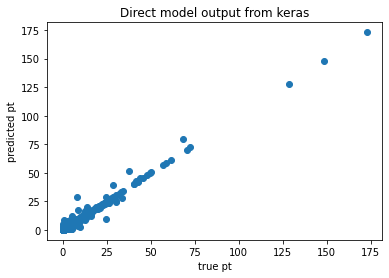

In [18]:
plt.title("Direct model output from keras")
plt.scatter(true_pts, pred_pts)
plt.xlabel("true pt")
plt.ylabel("predicted pt")

## Dynamic Range Quantiztion
* 4x smaller, 2x-3x speedup
* Reduced size upto 75%
* There are smallest accuracy loss

Source:
1. https://www.tensorflow.org/lite/performance/post_training_quantization

In [19]:
converter = tf.lite.TFLiteConverter.from_concrete_functions([full_model.get_concrete_function(Xdummy)])
tflite_model = converter.convert()

2024-01-27 00:34:01.271363: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2024-01-27 00:34:01.272254: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-01-27 00:34:15.155896: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-01-27 00:34:15.156558: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-01-27 00:34:16.131854: I tensorflow/compiler/mlir/lite/flatbuffer_export.cc:2138] Estimated count of arithmetic ops: 3.923 G  ops, equivalently 1.961 G  MACs


Write it out to a tflite file:



In [20]:
tflite_models_dir = pathlib.Path("/tmp/working1_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [21]:
tflite_model_file = tflite_models_dir/"working1_tflite_models.tflite"
tflite_model_file.write_bytes(tflite_model)

22424016

To quantize the model on export, set the optimizations flag to optimize for size:



In [22]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
tflite_model_quant_file = tflite_models_dir/"working_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)


2024-01-27 00:34:21.121573: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2024-01-27 00:34:21.121818: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-01-27 00:34:35.211640: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-01-27 00:34:35.211738: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-01-27 00:34:36.983976: I tensorflow/compiler/mlir/lite/flatbuffer_export.cc:2138] Estimated count of arithmetic ops: 3.923 G  ops, equivalently 1.961 G  MACs


6081472

As expected the resulting file, is approximately 1/4 the size.



Run the TFLite models



Test the model on the quantized data: https://www.tensorflow.org/lite/performance/post_training_quant



In [23]:
true_pts = []
pred_pts = []
pred_pts_quantized = []

interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()
input_index1 = interpreter.get_input_details()[0]["index"]
output_index1 = interpreter.get_output_details()[0]["index"]

interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()
input_index2 = interpreter_quant.get_input_details()[0]["index"]
output_index2 = interpreter_quant.get_output_details()[0]["index"]

for ibatch in range(len(Xs)):
#for ibatch in range(5):
    for iev in range(len(Xs[ibatch])):

        this_X = tf.expand_dims(Xs[ibatch][iev], 0)
        pad_size = [[0,0],[0,Xdummy.shape[1]-this_X.shape[1]], [0,0]]
        this_X = tf.pad(this_X, pad_size)
        this_ys = tf.pad(ys[ibatch][iev], pad_size[1:])
        
        interpreter.set_tensor(input_index1, this_X)
        interpreter.invoke()
        
        interpreter_quant.set_tensor(input_index2, this_X)
        interpreter_quant.invoke()
        
        mask_true_particles = this_ys[..., 0] != 0
        true_pt = this_ys[mask_true_particles][..., 2]
        output1 = interpreter.tensor(output_index1)()[0][mask_true_particles][..., 9]
        output2 = interpreter_quant.tensor(output_index2)()[0][mask_true_particles][..., 9]
        
        true_pts.append(true_pt)
        pred_pts.append(output1)
        pred_pts_quantized.append(output2)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [24]:
interpreter.get_input_details()

[{'name': 'x',
  'index': 0,
  'shape': array([  1, 256,  17], dtype=int32),
  'shape_signature': array([  1, 256,  17], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [25]:
interpreter.get_output_details()


[{'name': 'Identity',
  'index': 1483,
  'shape': array([  1, 256,  14], dtype=int32),
  'shape_signature': array([  1, 256,  14], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [26]:
flat_true_pts = np.hstack(true_pts)
flat_pred_pts = np.hstack(pred_pts)
flat_pred_pts_quantized = np.hstack(pred_pts_quantized)

In [27]:
flat_true_pts.shape, flat_pred_pts.shape, flat_pred_pts_quantized.shape

((4250,), (4250,), (4250,))

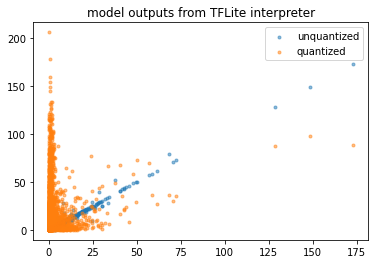

In [28]:
plt.title("model outputs from TFLite interpreter")
plt.scatter(flat_true_pts, flat_pred_pts, label="unquantized", marker=".", alpha=0.5)
plt.scatter(flat_true_pts, flat_pred_pts_quantized, label="quantized", marker=".", alpha=0.5)
plt.legend(loc="best")

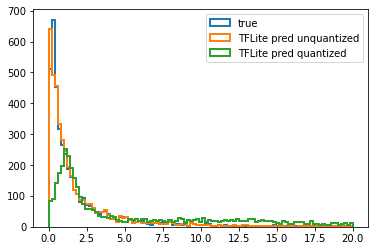

In [29]:
plt.hist(flat_true_pts, bins=np.linspace(0,20,100), histtype="step", label="true", lw=2);
plt.hist(flat_pred_pts, bins=np.linspace(0,20,100), histtype="step", label="TFLite pred unquantized", lw=2);
plt.hist(flat_pred_pts_quantized, bins=np.linspace(0,20,100), histtype="step", label="TFLite pred quantized", lw=2);
plt.legend(loc="best")

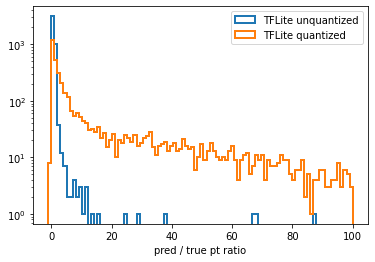

In [30]:
plt.hist(flat_pred_pts/flat_true_pts, bins=np.linspace(-1,100,101), histtype="step", lw=2, label="TFLite unquantized")
plt.hist(flat_pred_pts_quantized/flat_true_pts, bins=np.linspace(-1,100,101), histtype="step", lw=2, label="TFLite quantized")
#plt.axvline(1.0, color="black")
plt.yscale("log")
plt.xlabel("pred / true pt ratio")
plt.legend()

## Fp16 quantization 

* Representative Data is not required for this type of Quantization
* Supported Hardware: CPU, GPU
    
    
The advantages of float16 quantization are as follows:

* It reduces model size by up to half (since all weights become half of their original size).
* It causes minimal loss in accuracy.
* It supports some delegates (e.g. the GPU delegate) which can operate directly on float16 data, resulting in faster execution than float32 computations.

The disadvantages of float16 quantization are as follows:

* It does not reduce latency as much as a quantization to fixed point math.
* By default, a float16 quantized model will "dequantize" the weights values to float32 when run on the CPU. (Note that the GPU delegate will not perform this dequantization, since it can operate on float16 data.)

Source: 
* https://www.tensorflow.org/lite/performance/post_training_quantization#float16_quantization
* https://www.tensorflow.org/lite/performance/post_training_float16_quant
* https://www.tensorflow.org/lite/performance/model_optimization
    

In [31]:
converter = tf.lite.TFLiteConverter.from_concrete_functions([full_model.get_concrete_function(Xdummy)])
tflite_model = converter.convert()

2024-01-27 00:35:56.439701: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2024-01-27 00:35:56.440171: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-01-27 00:36:10.665096: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-01-27 00:36:10.665375: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-01-27 00:36:11.592975: I tensorflow/compiler/mlir/lite/flatbuffer_export.cc:2138] Estimated count of arithmetic ops: 3.923 G  ops, equivalently 1.961 G  MACs


In [32]:
# Writing the model to a `.tflite` file
tflite_models_dir = pathlib.Path("/tmp/working1_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"working1_tflite_models.tflite"
tflite_model_file.write_bytes(tflite_model)

22424016

To istead quantize the model to float 16 on export, first set the `optimizations` flag to use default optimizations. Then specify that float16 is the supported type on the target platform 

Source:
1. https://www.tensorflow.org/lite/performance/post_training_float16_quant

In [34]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

Finally, convert the model like usual. Note, by default the converted model will still use float input and outputs for invocation convenience.



In [36]:
tflite_fp16_model = converter.convert()
tflite_model_fp16_file = tflite_models_dir/"working_model_quant_fp16.tflite"
tflite_model_fp16_file.write_bytes(tflite_fp16_model)

2024-01-27 00:45:13.123364: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2024-01-27 00:45:13.123613: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-01-27 00:45:27.381081: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-01-27 00:45:27.381152: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-01-27 00:45:28.317104: I tensorflow/compiler/mlir/lite/flatbuffer_export.cc:2138] Estimated count of arithmetic ops: 3.923 G  ops, equivalently 1.961 G  MACs


11384020

Note how the resulting file is approximately `1/2` the size

In [38]:
ls -lh {tflite_models_dir}

total 39M
-rw-r--r--. 1 sraj zh  22M Jan 27 00:37 working1_tflite_models.tflite
-rw-r--r--. 1 sraj zh  11M Jan 27 00:45 working_model_quant_fp16.tflite
-rw-r--r--. 1 sraj zh 5.8M Jan 27 00:34 working_model_quant.tflite


In [39]:
true_pts = []
pred_pts = []
pred_pts_quantized = []

interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()
input_index1 = interpreter.get_input_details()[0]["index"]
output_index1 = interpreter.get_output_details()[0]["index"]

interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_fp16_file))
interpreter_quant.allocate_tensors()
input_index2 = interpreter_quant.get_input_details()[0]["index"]
output_index2 = interpreter_quant.get_output_details()[0]["index"]

for ibatch in range(len(Xs)):
#for ibatch in range(5):
    for iev in range(len(Xs[ibatch])):

        this_X = tf.expand_dims(Xs[ibatch][iev], 0)
        pad_size = [[0,0],[0,Xdummy.shape[1]-this_X.shape[1]], [0,0]]
        this_X = tf.pad(this_X, pad_size)
        this_ys = tf.pad(ys[ibatch][iev], pad_size[1:])
        
        interpreter.set_tensor(input_index1, this_X)
        interpreter.invoke()
        
        interpreter_quant.set_tensor(input_index2, this_X)
        interpreter_quant.invoke()
        
        mask_true_particles = this_ys[..., 0] != 0
        true_pt = this_ys[mask_true_particles][..., 2]
        output1 = interpreter.tensor(output_index1)()[0][mask_true_particles][..., 9]
        output2 = interpreter_quant.tensor(output_index2)()[0][mask_true_particles][..., 9]
        
        true_pts.append(true_pt)
        pred_pts.append(output1)
        pred_pts_quantized.append(output2)

In [40]:
interpreter.get_input_details()

[{'name': 'x',
  'index': 0,
  'shape': array([  1, 256,  17], dtype=int32),
  'shape_signature': array([  1, 256,  17], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [41]:
interpreter.get_output_details()

[{'name': 'Identity',
  'index': 1483,
  'shape': array([  1, 256,  14], dtype=int32),
  'shape_signature': array([  1, 256,  14], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [42]:
flat_true_pts = np.hstack(true_pts)
flat_pred_pts = np.hstack(pred_pts)
flat_pred_pts_quantized = np.hstack(pred_pts_quantized)

In [44]:
flat_true_pts.shape, flat_pred_pts.shape, flat_pred_pts_quantized.shape

((4250,), (4250,), (4250,))

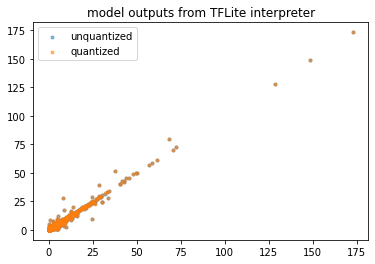

In [45]:
plt.title("model outputs from TFLite interpreter")
plt.scatter(flat_true_pts, flat_pred_pts, label="unquantized", marker=".", alpha=0.5)
plt.scatter(flat_true_pts, flat_pred_pts_quantized, label="quantized", marker=".", alpha=0.5)
plt.legend(loc="best")

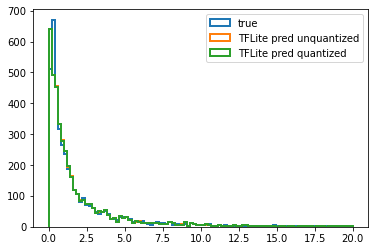

In [46]:
plt.hist(flat_true_pts, bins=np.linspace(0,20,100), histtype="step", label="true", lw=2);
plt.hist(flat_pred_pts, bins=np.linspace(0,20,100), histtype="step", label="TFLite pred unquantized", lw=2);
plt.hist(flat_pred_pts_quantized, bins=np.linspace(0,20,100), histtype="step", label="TFLite pred quantized", lw=2);
plt.legend(loc="best")

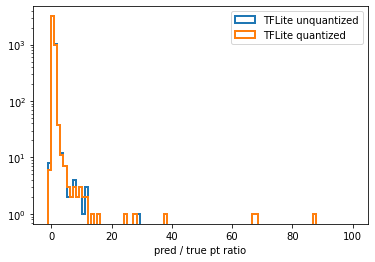

In [49]:
plt.hist(flat_pred_pts/flat_true_pts, bins=np.linspace(-1,100,101), histtype="step", lw=2, label="TFLite unquantized")
plt.hist(flat_pred_pts_quantized/flat_true_pts, bins=np.linspace(-1,100,101), histtype="step", lw=2, label="TFLite quantized")
# plt.axvline(1.0, color="black")
plt.yscale("log")
plt.xlabel("pred / true pt ratio")
plt.legend()